# Install dependecny

In [1]:
!pip install yellowbrick
!pip install pyclustering

You should consider upgrading via the '/home/ornela/myproject/venv_/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ornela/myproject/venv_/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler # normalization
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score 
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance

from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist

from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster import cluster_visualizer, cluster_visualizer_multidim
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.silhouette import silhouette


In [3]:
df = pd.read_csv("dataset/tennis_players.csv", skipinitialspace=True, sep=',', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 3885
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   2072 non-null   object 
 1   ratio                  2072 non-null   float64
 2   num_matches_2016-2019  2072 non-null   float64
 3   ratio_2016-2019        2072 non-null   float64
 4   num_matches_2020-2021  2072 non-null   float64
 5   ratio_2020-2021        2072 non-null   float64
 6   hand                   2072 non-null   object 
 7   gender                 2072 non-null   object 
 8   ioc                    2072 non-null   object 
 9   birth                  2072 non-null   float64
 10  ht                     2072 non-null   float64
 11  minutes                2072 non-null   float64
 12  perc_ace               2072 non-null   float64
 13  serv_won_tot_seve      2072 non-null   float64
 14  bpFaced                2072 non-null   float64
 15  perc

### Drop categorical data

In [4]:
del df['name']
del df['hand']
del df['gender']
del df['ioc']

### Drop most correlated attributes

In [5]:
corr_threshold = 0.9
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df.columns)):
    for j in range(i+1, len(df.columns)):
        corr = df[df.columns[i]].corr(df[df.columns[j]])
        if  corr > corr_threshold:
            print(df.columns[i] + "\t" + df.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
num_matches_2016-2019	bpFaced	0.9253
serv_won_tot_seve	perc_2ndwon	0.9248


In [6]:
del df['num_matches_2016-2019'] 
del df['bpFaced']
del df['serv_won_tot_seve']
del df['perc_2ndwon']

In [7]:
df.head()

,ratio,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,perc_df,perc_v_ace,perc_v_df,perc_v_1stwon
0,0.181818,0.200000,1.0,0.000000,1996.0,187.076923,86.694444,14.98,12.32,8.82,5.88,75.79
1,0.477707,0.478873,15.0,0.466667,1994.0,170.857143,61.621951,1.30,4.67,3.18,5.39,39.67
2,0.500000,0.461538,3.0,0.666667,1998.0,183.800000,86.875000,20.59,10.89,7.12,10.10,70.86
4,0.588710,0.576577,13.0,0.692308,1992.0,172.137193,62.577626,3.37,11.18,3.83,7.73,52.62
5,0.153846,0.153846,0.0,0.000000,1995.0,172.137193,59.409091,0.00,16.30,0.51,2.55,11.88


### MinMax Normalization before clustering

In [8]:
scaler = MinMaxScaler()
df_norm_minmax = scaler.fit_transform(df.values)
#print(df_norm_minmax)

### ZScore Normalization before clustering

In [9]:
scaler = StandardScaler()
df_norm_zscore = scaler.fit_transform(df.values) 
#print(df_norm_zscore)

# Partitional and center-based clustering: K-Means

**Objective:** Clusters the data into $k$ groups.
* **Init step:** Select k points at random as cluster centers.
* **Assignment step:** Assign each instance to the cluster with the closest mean according to the distance function.
* **Update step**: Calculate the new means to be the centroids of the instances in the new clusters.
* ***Repeat*** steps 2 and 3 until the assignment no longer change.

There is no guarantee that the optimum is found using this algorithm.

## Problems

* Initial Centroids
* Number of clusters

### Number of clusters decision: Elbow Method on the clusters Inertia
In cluster analysis, the elbow method is a heuristic used in determining the optimal number of clusters in a data set. 
<br>It consists of plotting the SSE as a function of the number of clusters, and **picking the elbow** of the curve as the *k* to use.

We start from an initial value of 2 and we keep computing the clusterization until we reach the value of 30, our choice for the maximum value of *k*. 
<br>Considering ranges of k differing in size may lead to slightly different elbows, so we also plot the curves of the intervals [2,10] and [2,20].


## Scoring parameter metrics
https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

* **Distortion:** Is the default method, it computes the mean Sum of Squared distances from each point to its assigned center.

* **Average Silhouette:** It is an indicator of both separation and cohesion among clusters. We look for the clusterization with the highest average value among those computed by K-means. It computes the mean ratio of intra-cluster and nearest cluster distance.

* **Calinski Harabasz:** It computes the ratio of dispersion between and within clusters.


The elbow_locate=True means that it automatically finds the 'elbow' or 'knee' which likely corresponds to the optimal value of k using the 'knee point detection algorithm'. This algorithm finds the point of maximum curvature, which in a well-behaved clustering problem also represents the pivot of the elbow curve.

NOTE: the 'elbow' method does not work well if the data is not very clustered, in this case there is a smooth curve and the optimal value of k will be unclear. Then other scoring methods such as BIC or SSE, also can be used to explore if clustering is a correct choice

The blue line is the function output.
The vertical dashed line signs the optimal k value.
The green line signs the time needed for each clustering of different k.
If there is a strong elbow (point of inflection on the curve) there is the optimal k.


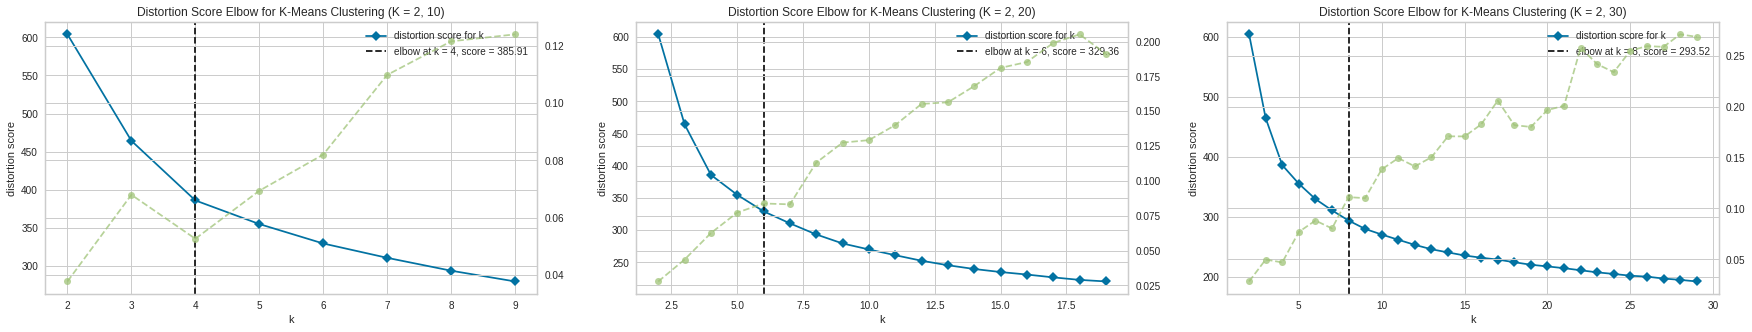

The arm is up going.


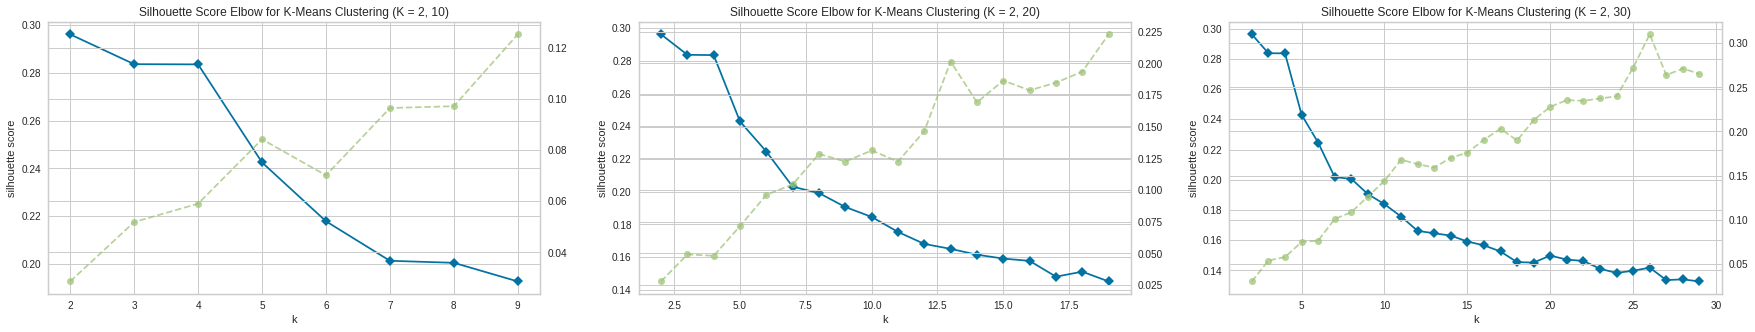

It highlights a global maxima for k equals to 2 and a local maxima for k equals to 3 or 4
We consider these values to the list of candidates for the optimal value of k.


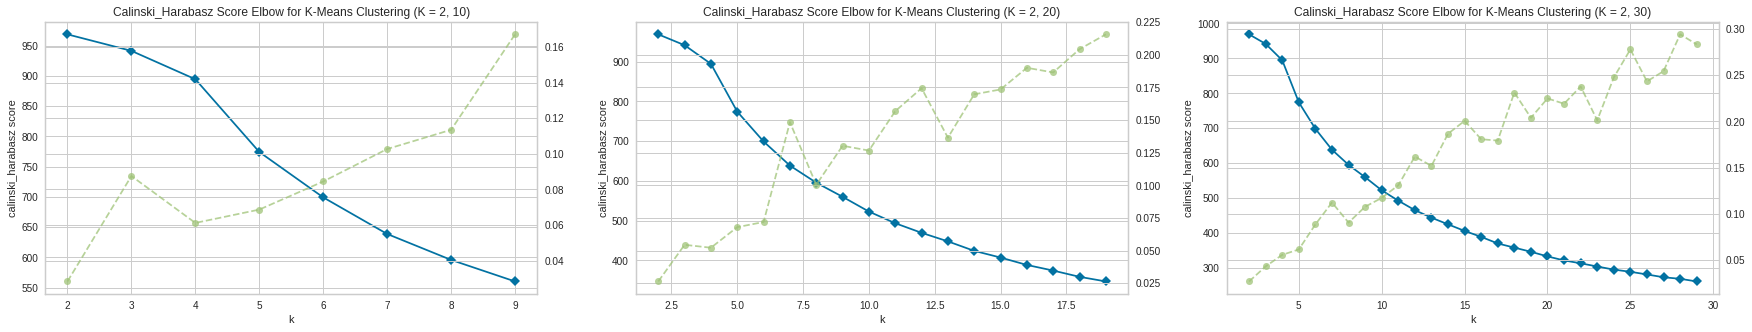

The arm is down going.
The line chart (both for Distortion and Calinski) looks like an arm then the elbow point is the best value of k


In [10]:
df_norm = df_norm_minmax # can try both the normalized forms without obtaining differences
#df_norm = df_norm_zscore

k_start = [2]
k_max = [10, 20, 30]
Ks = []
model = KMeans()

print("The blue line is the function output.")
print("The vertical dashed line signs the optimal k value.")
print("The green line signs the time needed for each clustering of different k.")
print("If there is a strong elbow (point of inflection on the curve) there is the optimal k.")
f, axs = plt.subplots(nrows=1, ncols=len(k_max), figsize=(30,5)) # print the elbow plots
for i in range(len(k_max)):
    vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='distortion', timings=True, ax=axs[i])
    vis.fit(df_norm) #fit the data to the visualizer 
    axs[i].set_title('Distortion Score Elbow for K-Means Clustering (K = ' + str(k_start[0]) + ', ' + str(k_max[i]) + ')' )
    axs[i].set_ylabel('distortion score')
    axs[i].set_xlabel('k')
    axs[i].legend(['distortion score for k','elbow at k = ' + str(vis.elbow_value_) + ', score = ' + '{:.2f}'.format(vis.elbow_score_)])
    if (vis.elbow_value_ not in Ks) and (vis.elbow_value_ != None):
        Ks.append(vis.elbow_value_)
plt.show() #finalize and render the figure
plt.close()
print("The arm is up going.")

f, axs = plt.subplots(nrows=1, ncols=len(k_max), figsize=(30,5))
for i in range(len(k_max)):
    #vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='silhouette', timings=True, ax=axs[i]))
    vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='silhouette', timings=True, ax=axs[i], locate_elbow=False)
    vis.fit(df_norm)  
    axs[i].set_title('Silhouette Score Elbow for K-Means Clustering (K = ' + str(k_start[0]) + ', ' + str(k_max[i]) + ')' )
    axs[i].set_ylabel('silhouette score')
    axs[i].set_xlabel('k')
plt.show()
plt.close()
print("It highlights a global maxima for k equals to 2 and a local maxima for k equals to 3 or 4")
print("We consider these values to the list of candidates for the optimal value of k.")


f, axs = plt.subplots(nrows=1, ncols=len(k_max), figsize=(30,5))
for i in range(len(k_max)):
    #vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='calinski_harabasz', timings=True, ax=axs[i])
    vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='calinski_harabasz', timings=True, ax=axs[i], locate_elbow=False)
    vis.fit(df_norm)  
    axs[i].set_title('Calinski_Harabasz Score Elbow for K-Means Clustering (K = ' + str(k_start[0]) + ', ' + str(k_max[i]) + ')' )
    axs[i].set_ylabel('calinski_harabasz score')
    axs[i].set_xlabel('k')
plt.show()
plt.close()
print("The arm is down going.")

print("The line chart (both for Distortion and Calinski) looks like an arm then the elbow point is the best value of k")

### Number of clusters decision: Intercluster Distance Maps
It displays an embedding of the cluster centers in 2D with the distance to other centers preserved.
i.e. the closer to centers are in the visualization, the closer they are in the original feature space
Each cluster is sized according to a scoring metric. By default, they are sized by membership, i.e. the number of instances that belong to each center. This gives a sense of the relative importance of clusters.

NOTE: because 2 clusters overlap in the 2D space, it does not imply that they overlap in the original feature space

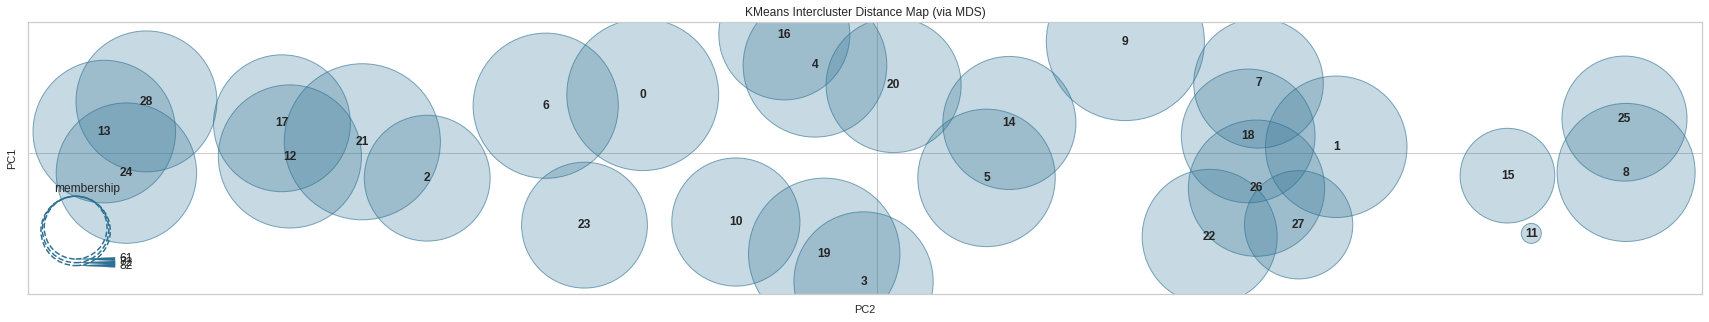

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [11]:
f, axs = plt.subplots(nrows=1, ncols=1, figsize=(30,5))
vis = InterclusterDistance(model)
vis.fit(df_norm)  
vis.show()


## Visualization of the clusters in 2 dimensions

Parameters:
* **n_clusters**: The number of clusters
* **n_init**: Number of time k-means will be run with different initial centroids. The final results will be the best output in terms of inertia.
* **max_iter**: Maximum number of iterations of the k-means algorithm for a single run.

Output:
* **labels_**: Labels of each point
* **cluster\_centers_**: Coordinates of cluster centers
* **inertia_**: Sum of squared distances of samples to their closest cluster center.

KMeans()
{0: 306, 1: 203, 2: 332, 3: 264, 4: 269, 5: 281, 6: 226, 7: 191}


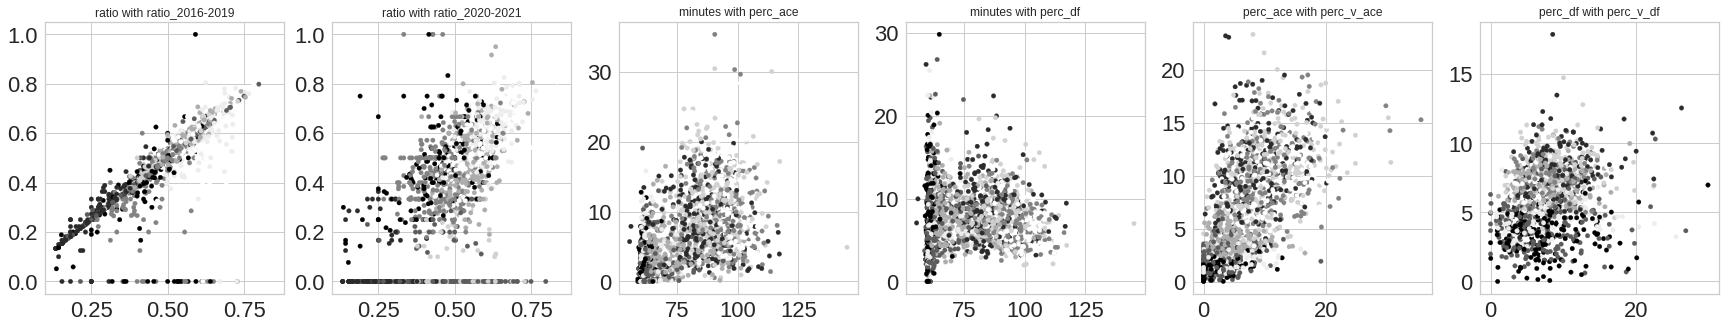

KMeans(max_iter=100, n_clusters=2)
{0: 925, 1: 1147}


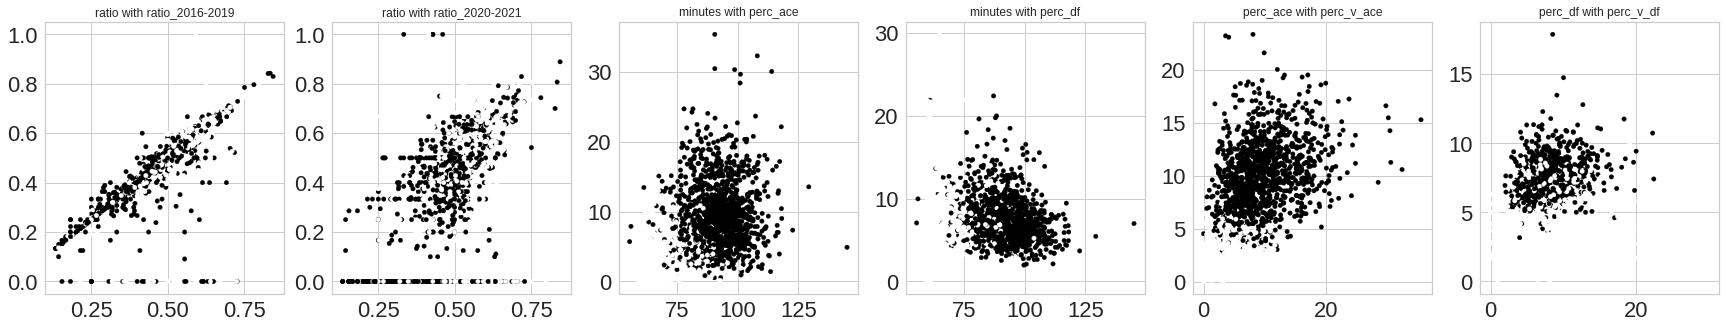

KMeans(max_iter=100, n_clusters=3)
{0: 715, 1: 585, 2: 772}


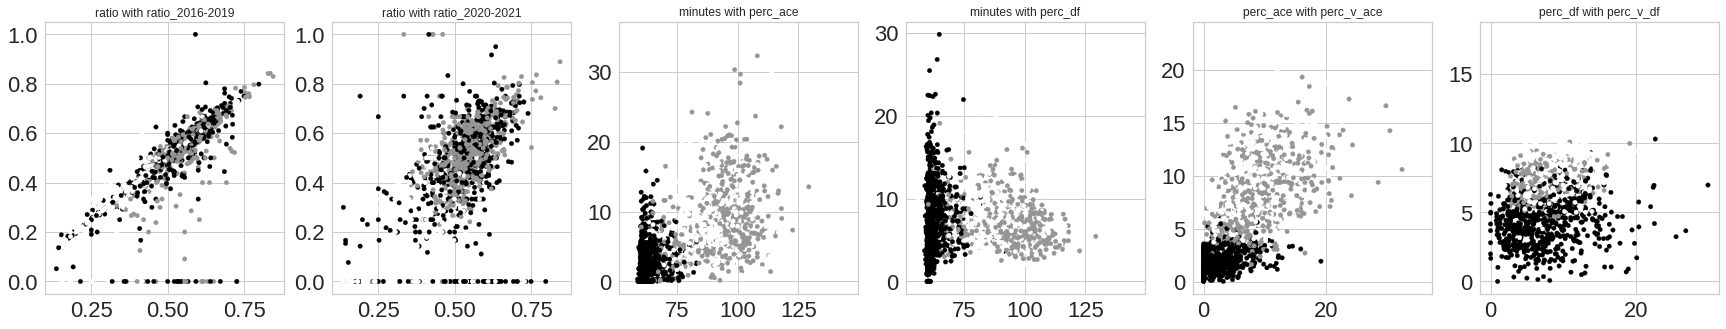

KMeans(max_iter=100, n_clusters=4)
{0: 532, 1: 657, 2: 524, 3: 359}


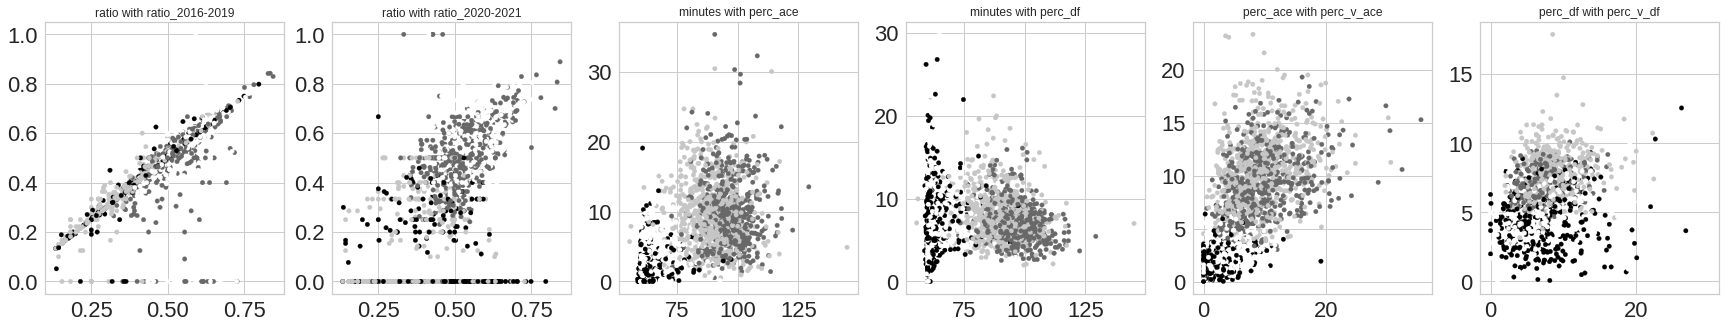

In [60]:
df_norm = df_norm_minmax # can try both the normalized forms without obtaining differences
#df_norm = df_norm_zscore

for i in range(1,5):
    if i==1:
        kmeans = KMeans(n_clusters=8, n_init=10, max_iter=300) #default parameters
    else:
        kmeans = KMeans(n_clusters=i, n_init=10, max_iter=100) #global max k=2, local max k=3,4 from the Silhouette score analyisis

    print(kmeans.fit(df_norm)) 
    #print( kmeans.labels_[:5] ) #labels
    #print( np.unique(kmeans.labels_, return_counts=True) ) # observing the size of each cluster
    hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
    print( dict(zip(bins, hist)) )
        
    f, axs = plt.subplots(ncols=6, figsize=(30,5))
    for j in range(0,6):
        if j==0:
            df1,df2 = df['ratio'],df['ratio_2016-2019']
        elif j==1:
            df1,df2 = df['ratio'],df['ratio_2020-2021']
        elif j==2:
            df1,df2 = df['minutes'],df['perc_ace']
        elif j==3:
            df1,df2 = df['minutes'],df['perc_df']
        elif j==4:
            df1,df2 = df['perc_ace'],df['perc_v_ace']
        elif j==5:
            df1,df2 = df['perc_df'],df['perc_v_df']

        axs[j].scatter(df1, df2, s=20, c=kmeans.labels_) # i colori vengono presi qua
        axs[j].tick_params(axis='both', which='major', labelsize=22)
        axs[j].set_title(df1.name+" with "+df2.name)

    plt.show()
    plt.close()

# DBSCAN
Parameters:
* **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
* **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself.


To try different configurations of parameters, we set 3 vectors:
* **eps_values**: Vector of eps
* **min_samples_values**: Vector of min_samples
* **metrics**: Vector of metrics



In total, we try 1008 different configuration, however, how the reader can see below, we can't exploit a good clustering of our data using dbscan. 

In [13]:
scaled=df_norm_minmax
num_features=df

In [14]:
eps_values = [0.005, 0.01, 0.05, 0.08, 0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
min_samples_values = [3, 5, 6, 7, 8, 9, 10, 15, 16, 17, 18, 20]
metrics = ['euclidean'] #'cityblock', 'cosine', 'l1', 'l2', 'manhattan']
dbscan = []
dbscan_pair = []
k = 0
for metric in metrics:
    for i in range(len(eps_values)):
        for j in range(len(min_samples_values)):
            d = DBSCAN(eps=eps_values[i], min_samples=min_samples_values[j]) # algorithmic parameters
            dbscan.append(d.fit(scaled))
            if (len(np.unique((dbscan[k].labels_))) > 1):
                s = silhouette_score(scaled, dbscan[k].labels_)
                pair = (dbscan[k], s)
                dbscan_pair.append(pair)
            k = 1 + k


### Cluster Validation

To evaluete our cluster, sort by second component of dbscan_pair (that contain the pairs <dbscan, silhouette>) and take the last ten elements, these are the clusters with the greater silhouette. Then, visualize the coefficient, the number of clusters and their cardinality. From the results below, can be notice that best dbscans are composed by an eps = 0.45 and different values of min_sample, however silhouette values are small, the max value found are around 0.2. Also, best dbscans obtain only one big cluster and a very small cluster formed by outliers. So, from these results, it's possible to deduce that DBSCAN is not very well to clustering our data. 

In [15]:
db_best_k = sorted(dbscan_pair, key=lambda x: x[1])
db_best_k = db_best_k[-10:]

In [16]:
for i in range(len(db_best_k)):
    print(db_best_k[i][0], np.unique(db_best_k[i][0].labels_, return_counts=True))
    print('Silhouette ', db_best_k[i][1])

DBSCAN(min_samples=10) (array([-1,  0]), array([   3, 2069]))
Silhouette  0.22789224245170314
DBSCAN(min_samples=15) (array([-1,  0]), array([   3, 2069]))
Silhouette  0.22789224245170314
DBSCAN(min_samples=16) (array([-1,  0]), array([   3, 2069]))
Silhouette  0.22789224245170314
DBSCAN(min_samples=17) (array([-1,  0]), array([   3, 2069]))
Silhouette  0.22789224245170314
DBSCAN(eps=0.45, min_samples=8) (array([-1,  0]), array([   9, 2063]))
Silhouette  0.2380254089735075
DBSCAN(eps=0.45, min_samples=9) (array([-1,  0]), array([   9, 2063]))
Silhouette  0.2380254089735075
DBSCAN(eps=0.45, min_samples=10) (array([-1,  0]), array([  10, 2062]))
Silhouette  0.23824513526626465
DBSCAN(eps=0.45, min_samples=6) (array([-1,  0]), array([   7, 2065]))
Silhouette  0.23835374201796186
DBSCAN(eps=0.45, min_samples=7) (array([-1,  0]), array([   8, 2064]))
Silhouette  0.23977206912294763
DBSCAN(eps=0.45) (array([-1,  0]), array([   5, 2067]))
Silhouette  0.24420535086747633


To completness, it's showed also the best results in case dbscan identify more then two clusters (at least one cluster apart custer -1 and 0). Obviously the silhouette it's worste then before and also in this case we have a very big cluster and other smallest one.

In [17]:
db_two = []
for i in range(len(dbscan_pair)):
    if len(np.unique(dbscan_pair[i][0].labels_)) > 2:
        db_two.append(dbscan_pair[i])

In [18]:
db_two = sorted(db_two, key=lambda x: x[1])
db_two = db_two[-5:]

In [19]:
for i in range(len(db_two)):
    print(np.unique(db_two[i][0].labels_, return_counts=True), 'sil', db_two[i][1])

(array([-1,  0,  1,  2]), array([871, 577, 281, 343])) sil 0.05418768833939894
(array([-1,  0,  1]), array([ 146, 1916,   10])) sil 0.0570478303951623
(array([-1,  0,  1,  2,  3]), array([903, 346, 281, 200, 342])) sil 0.06075586894930861
(array([-1,  0,  1]), array([832, 592, 648])) sil 0.07720727866120973
(array([-1,  0,  1]), array([  72, 1993,    7])) sil 0.0907512605774378


### Visualization
Below is showed scatter plot of the best dbscan formed by eps = 0.45 and min_sample = 10. 

In [20]:
def scatter_subplots(cell, x, y, x_label, y_label, db):
    cell.scatter(x, y, c=db.labels_, s=25)
    plt.tick_params(axis='both', which='major', labelsize=15)
    #cell.set_title('Corr(' + x_label + ',' + y_label +'): ' + str(x.corr(y)))
    cell.set_xlabel(x_label)
    cell.set_ylabel(y_label)


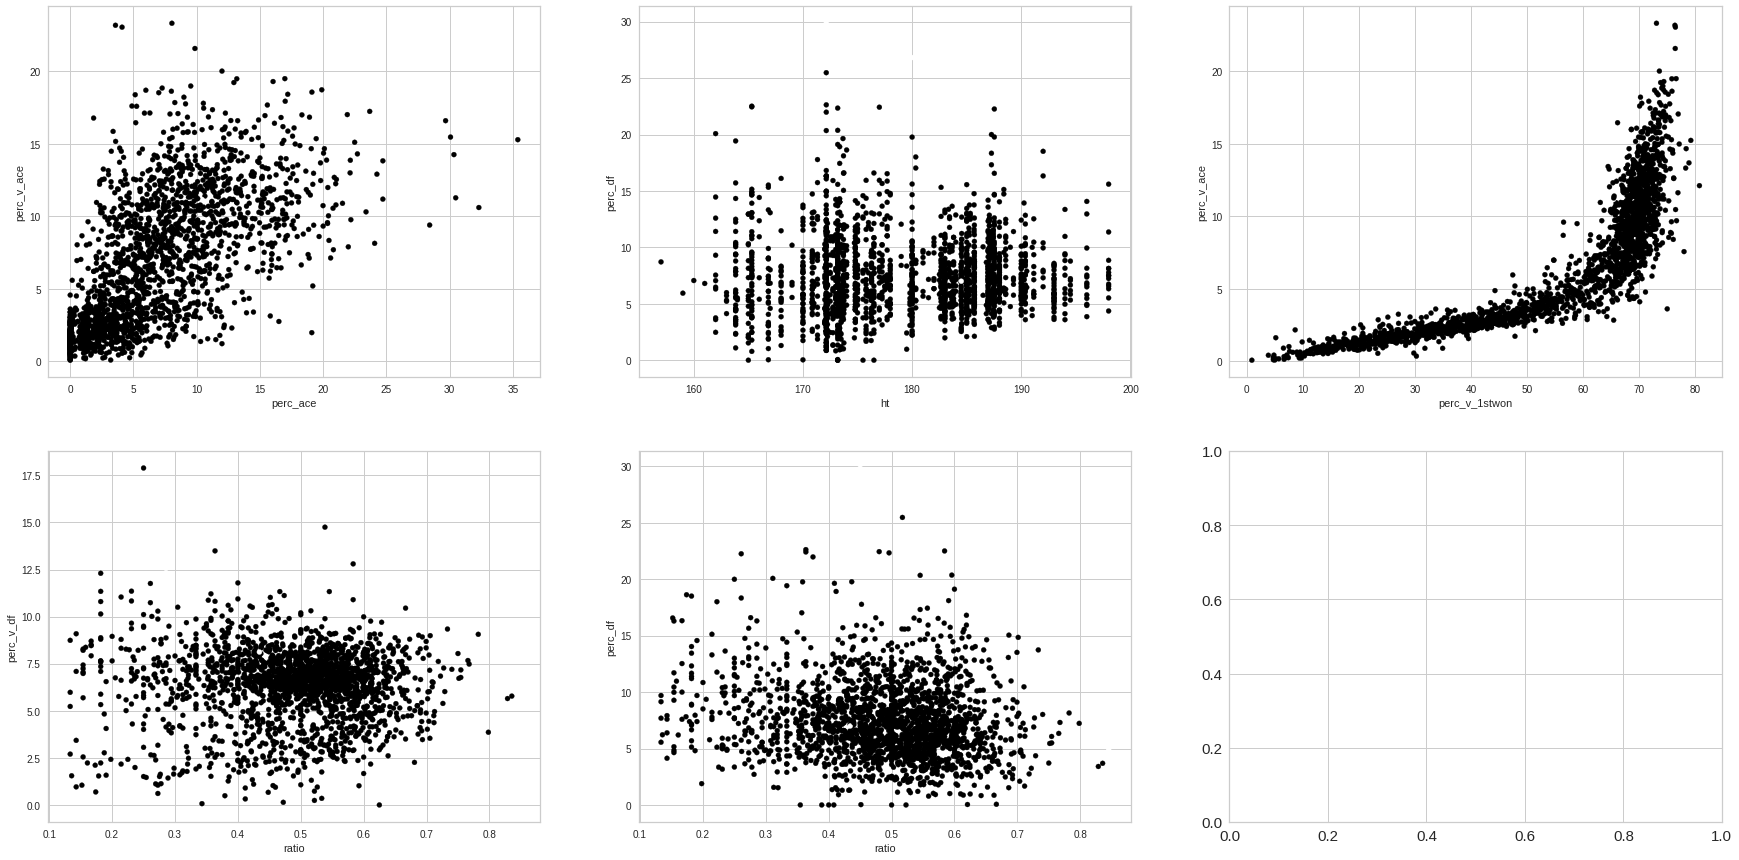

In [21]:
f, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(30,15))
best_db = db_best_k[-1][0]
scatter_subplots(axs[0][0], num_features.perc_ace, num_features.perc_v_ace, 'perc_ace', 'perc_v_ace', best_db)
#scatter_subplots(axs[0][1], num_features.ratio, num_features.serv_won_tot_seve, 'ratio', 'serv_won_tot_seve', best_db)
scatter_subplots(axs[0][1], num_features.ht, num_features.perc_df, 'ht', 'perc_df', best_db)
scatter_subplots(axs[0][2], num_features.perc_v_1stwon, num_features.perc_v_ace, 'perc_v_1stwon', 'perc_v_ace', best_db)

#scatter_subplots(axs[1][0], num_features.minutes, num_features.serv_won_tot_seve, 'minutes', 'serv_won_tot_seve', best_db)
#scatter_subplots(axs[1][0], df.minutes, num_features.bpFaced, 'minutes', 'bpFaced', best_db)
scatter_subplots(axs[1][0], num_features.ratio, num_features.perc_v_df, 'ratio', 'perc_v_df', best_db)
scatter_subplots(axs[1][1], num_features.ratio, num_features.perc_df, 'ratio', 'perc_df', best_db)


## Hierarchical clustering 

#### There are 2 kinds of hierarchical clustering: agglomerative and divisive. In the following, there are some example of the agglomerative clustering using scipy. The scipy library allows for hierachical clusters by exploiting the linkage function and then the dendrogram. The first function, given a matrix of pair-wise distances, computes the agglomerative clustering. There are 2 parameters: the method, that can be single, complete, ward, average, weighted, centroids and median, and the metric used to compute the distances, such as euclidean or cosine. Then, with the dendrogram function, it is possible to visualize the result obtained. This kind of clustering is also possible with scikit-learn library, but the dendrogram visualization is not directly available.


selezione dei parametri, qui decido i metodi da utilizzare per i cluster e gli step che mi serviranno successivamente per determinare i migliori cluster

In [22]:
#set data for MinMax
data=df_norm_minmax
steps = [0.001, 0.01, 0.01, 0.1]

#set data for Z-Score
#data=df_norm_zscore
#steps = [0.01, 0.1, 0.1, 3]

methods = ['single', 'complete', 'average', 'ward']

In [23]:
def plot_dendrogram(model, **kwargs):

    n_sample = np.zeros(model.children_.shape[0])
    samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < samples:
                current_count += 1 
            else:
                current_count += n_sample[child_idx - samples]
        n_sample[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, n_sample]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

funzione per rappresentare i grafici dei vari metodi

In [24]:
def plot_graph(axs,i,c_thresholds):
    axs[i].set_title('Hierarchical Clustering from ' + methods[i] + ' \n Color Threshold: ' + '{:2.4f}'.format(c_thresholds))
    axs[i].set_xlabel('PlayerID or (Cluster Size)')
    axs[i].set_ylabel('Distance')
    axs[i].axhline(c_thresholds, ls='--', color='r')
    return axs


Calcolo l'altezza del taglio di default

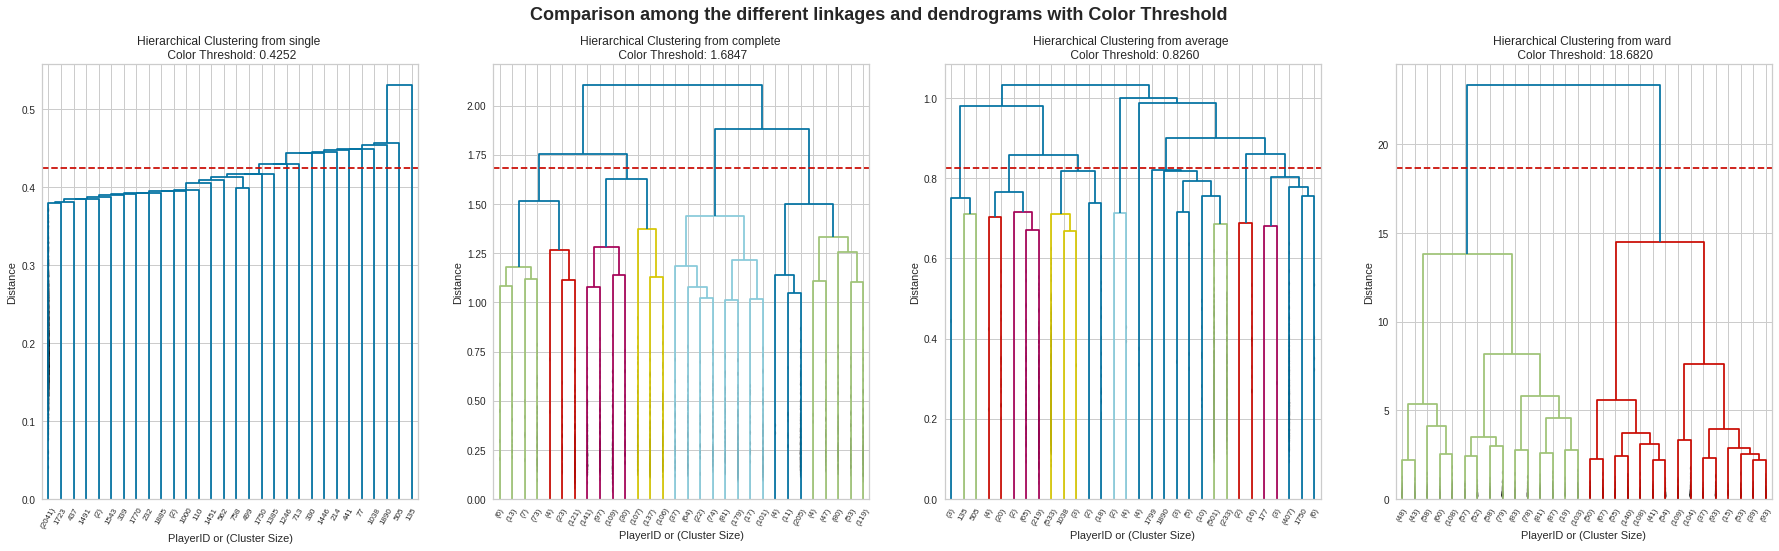

In [25]:
#for each method we go to calculate the agglomerative cluster and then print on the screen the various dendrograms associated with the respective default treshold
color_thresholds = []

f, axs = plt.subplots(ncols=4, figsize=(31,8))

for i in range(len(methods)):
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage=methods[i]).fit(data) 
    plot_dendrogram(model, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True, ax=axs[i])
    link_matrix = linkage(data, methods[i])
    #mi prendo il treshold pari a 4/5 della dimensione di ciascuna matrice di linkage (terza colonna)
    c_threshold=0.8*max(link_matrix[:,2]) 
    axs=plot_graph(axs,i,c_threshold)

plt.suptitle(('Comparison among the different linkages and dendrograms with Color Threshold'), fontsize=18, fontweight='bold')
plt.show()

## Identifying the best cut

Now to find the best number of clusters we need to find a correct threshold value, in our case we have defined ourselves as a function that iterates step by step. The method to be used, the steps through which to iterate and the normalized data takes function as input. We'll take the cluster for each methods with most occurency (maximum distance)

In [26]:
def get_best_cut(linkage, step, norm_data):
    clusters_number = []
    distances = []
    n_clusters = 0
    i = 0

    while n_clusters != 1:
        threshold = i*step
        model = AgglomerativeClustering(distance_threshold=threshold, n_clusters=None, affinity='euclidean', linkage=linkage).fit(norm_data)
        i = i + 1

        n_clusters = model.n_clusters_
        distances.append(threshold)
        clusters_number.append(n_clusters)

    df = pd.DataFrame()
    df['distance'] = distances
    df['n_clusters'] = clusters_number
    
    n_for_opt_cut = df.groupby('n_clusters').size().agg(['idxmax'])[0]
    distance = df[df.n_clusters == n_for_opt_cut].distance.min()
    
    print('Analysis for ' + linkage + ' reached n_clusters = 1 in ' + str(i) + ' steps')
   
    return n_for_opt_cut, distance

We search for the best cut within each of the four dendrograms.

In [27]:
best_clusters = []
heights = []

for i in range(len(methods)):
    n_for_opt_cut, height = get_best_cut(methods[i], steps[i], data)
    best_clusters.append(n_for_opt_cut)
    heights.append(height)
    
hierarchical_distances = pd.DataFrame()
hierarchical_distances['method'] = methods
hierarchical_distances['clusters_best_cut'] = best_clusters
hierarchical_distances['distance'] = heights
hierarchical_distances.set_index(['method'], inplace=True)

hierarchical_distances

Analysis for single reached n_clusters = 1 in 533 steps
Analysis for complete reached n_clusters = 1 in 212 steps
Analysis for average reached n_clusters = 1 in 105 steps
Analysis for ward reached n_clusters = 1 in 235 steps


,clusters_best_cut,distance
method,,
single,2,0.458
complete,2,1.890
average,5,0.910
ward,2,14.600


We plot the dendrograms again, this time highlighting the best cut identified above.

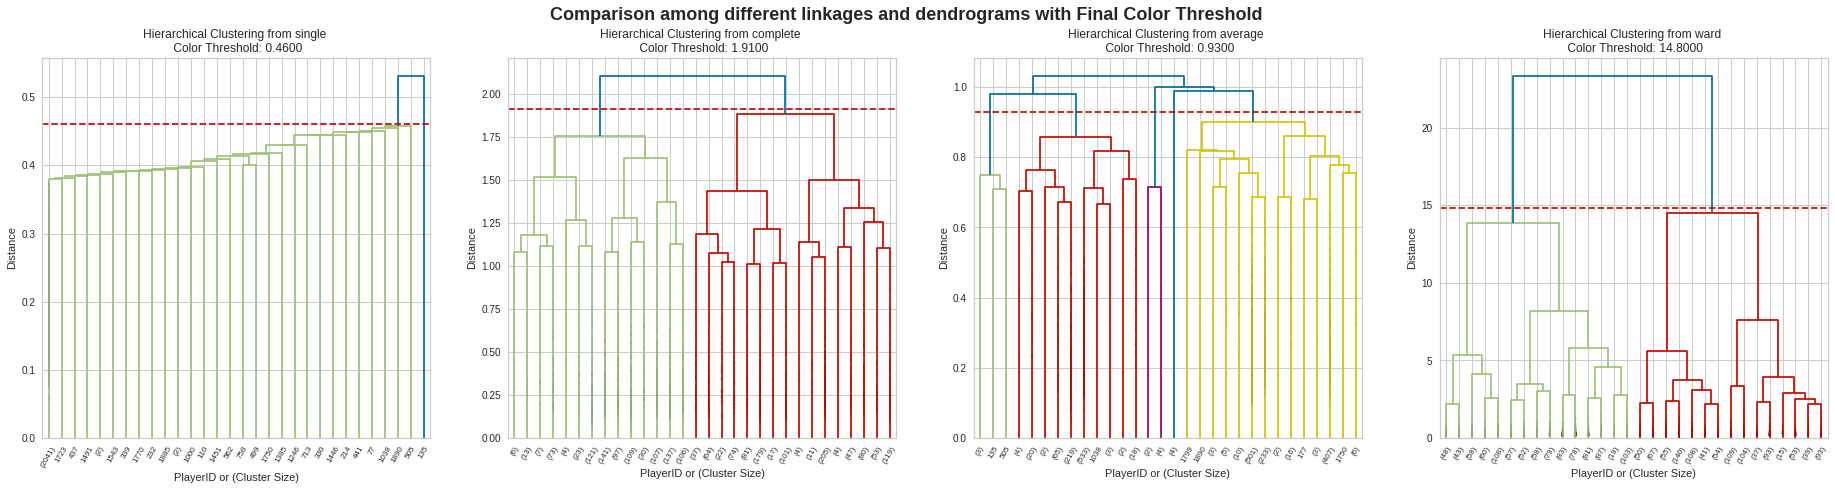

In [28]:
# plot dendrograms

f, axs = plt.subplots(ncols=4, figsize=(32,7))

for i in range(len(methods)):
    color_threshold = hierarchical_distances.loc[methods[i]].distance
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage=methods[i]).fit(data) 
    plot_dendrogram(model, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True, ax=axs[i], color_threshold=color_threshold)
  
    axs=plot_graph(axs,i,color_threshold + steps[i]*2)

plt.suptitle(('Comparison among different linkages and dendrograms with Final Color Threshold'),
             fontsize=18, fontweight='bold')
plt.show()

We compute and store the labels associated with each cut.

In [29]:
clusters_labels = pd.DataFrame()

In [30]:
for i in range(len(methods)):
    opt_n_clusters = int(hierarchical_distances.loc[methods[i]].clusters_best_cut)
    temp = AgglomerativeClustering(n_clusters=opt_n_clusters, affinity='euclidean', linkage=methods[i])
    labels=temp.fit_predict(data)
    clusters_labels[methods[i]] = labels
    print(methods[i] , labels)

clusters_labels[['single', 'complete', 'average', 'ward']]

single [0 0 0 ... 0 0 0]
complete [0 1 0 ... 1 0 1]
average [0 1 0 ... 1 0 1]
ward [0 1 0 ... 1 0 1]


,single,complete,average,ward
0,0,0,0,0
1,0,1,1,1
2,0,0,0,0
3,0,1,1,1
4,0,1,1,1
...,...,...,...,...
2067,0,1,0,1
2068,0,1,1,1
2069,0,1,1,1
2070,0,0,0,0


We compare the four clusterings by visualizing the distribution of the points among their clusters.

## Data Distribution graph with different algorithms

In [31]:
def comparison(a,b):
    f, axs = plt.subplots(nrows=1, ncols=4, figsize=(32,12))
    for i in range(len(methods)):
        labels = clusters_labels[methods[i]]
        opt_n_clusters = int(hierarchical_distances.loc[methods[i]].clusters_best_cut)
        scatter = axs[i].scatter(df[a], df[b], c=labels, s=20, cmap='cividis')
        axs[i].set_title('Scatter('+a+', '+b+') \n Method: ' + methods[i] + ', \n Number clusters: ' + str(opt_n_clusters), fontdict={'fontsize': 'large'})
        axs[i].set_xlabel(a, fontdict={'fontsize': 'large'})
        axs[i].set_ylabel(b, fontdict={'fontsize': 'large'})

        # produce a legend with the unique colors from the scatter
        dbs_population = np.unique(labels, return_counts=True)

        legend1 = axs[i].legend(*scatter.legend_elements(), #legend_elements creates legend handles and labels for a PathCollection.
                            loc="lower center", title="Labels")

        axs[i].add_artist(legend1)

        # produce a legend 
        secondlegend = []
        classes = np.unique(labels).shape[0]

        for j in range(classes):
            secondlegend.append("{} has {} points".format(j, dbs_population[1][j]))
        handles = scatter.legend_elements()[0]
        labels_2 = secondlegend
        legend2 = axs[i].legend(handles, labels_2, loc="lower right", title="Distribution")

    plt.suptitle(('Comparison of clusterings from different algorithms'),
                 fontsize=24, fontweight='bold')

    plt.show()

### perc_v_ace-perc_v_1stwon

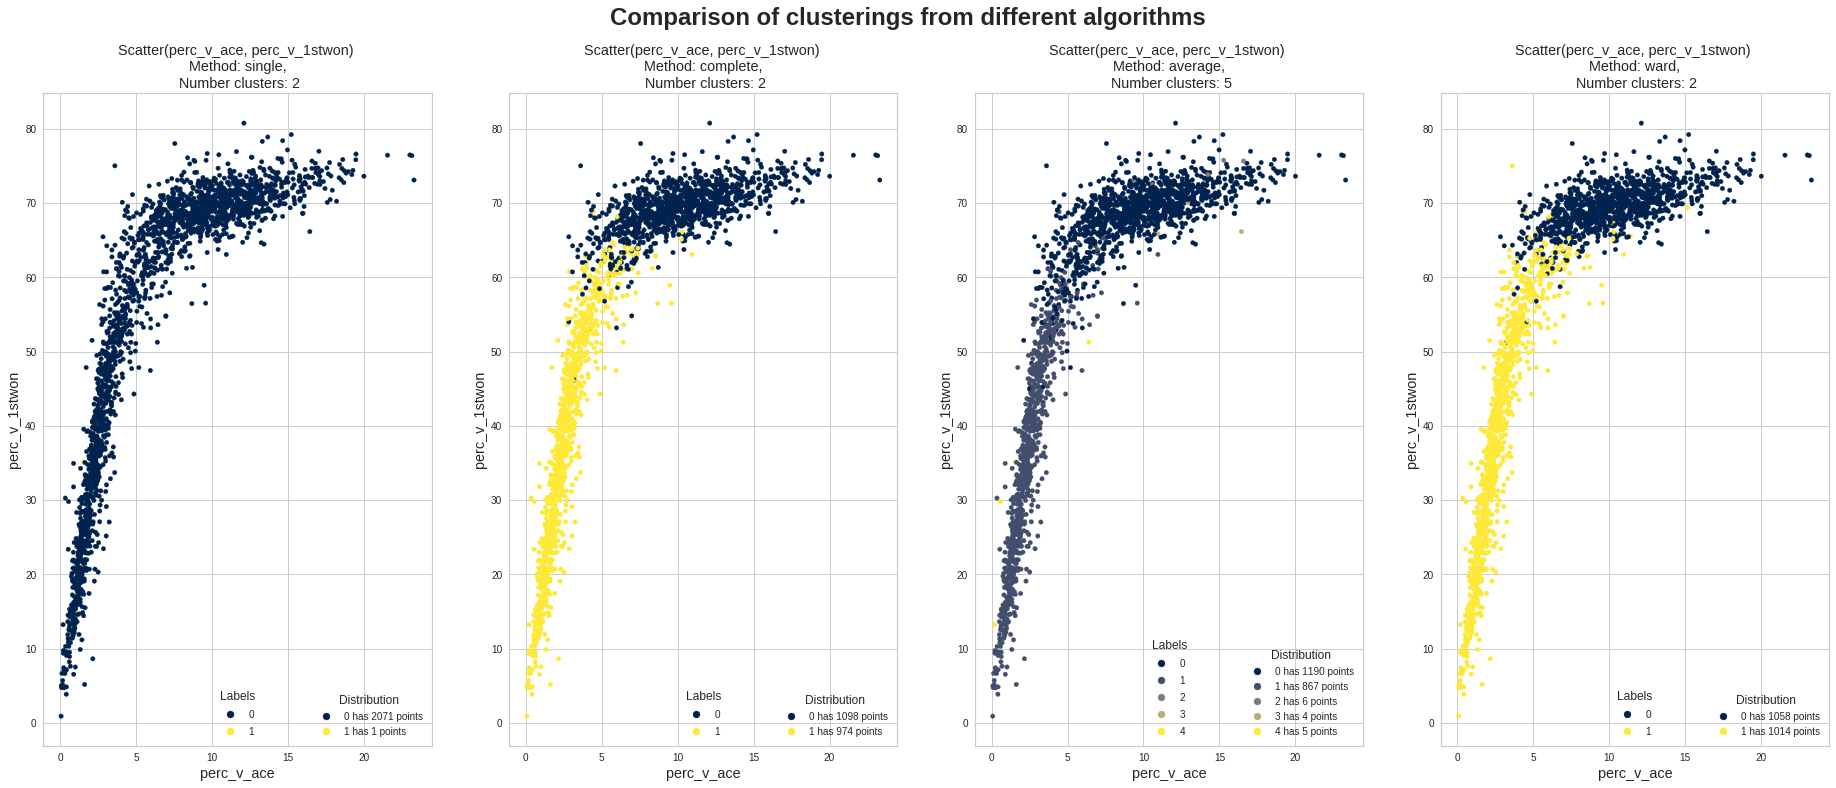

In [32]:
a, b = 'perc_v_ace', 'perc_v_1stwon'
comparison(a,b)


### perc_v_ace-perc_v_1stwon

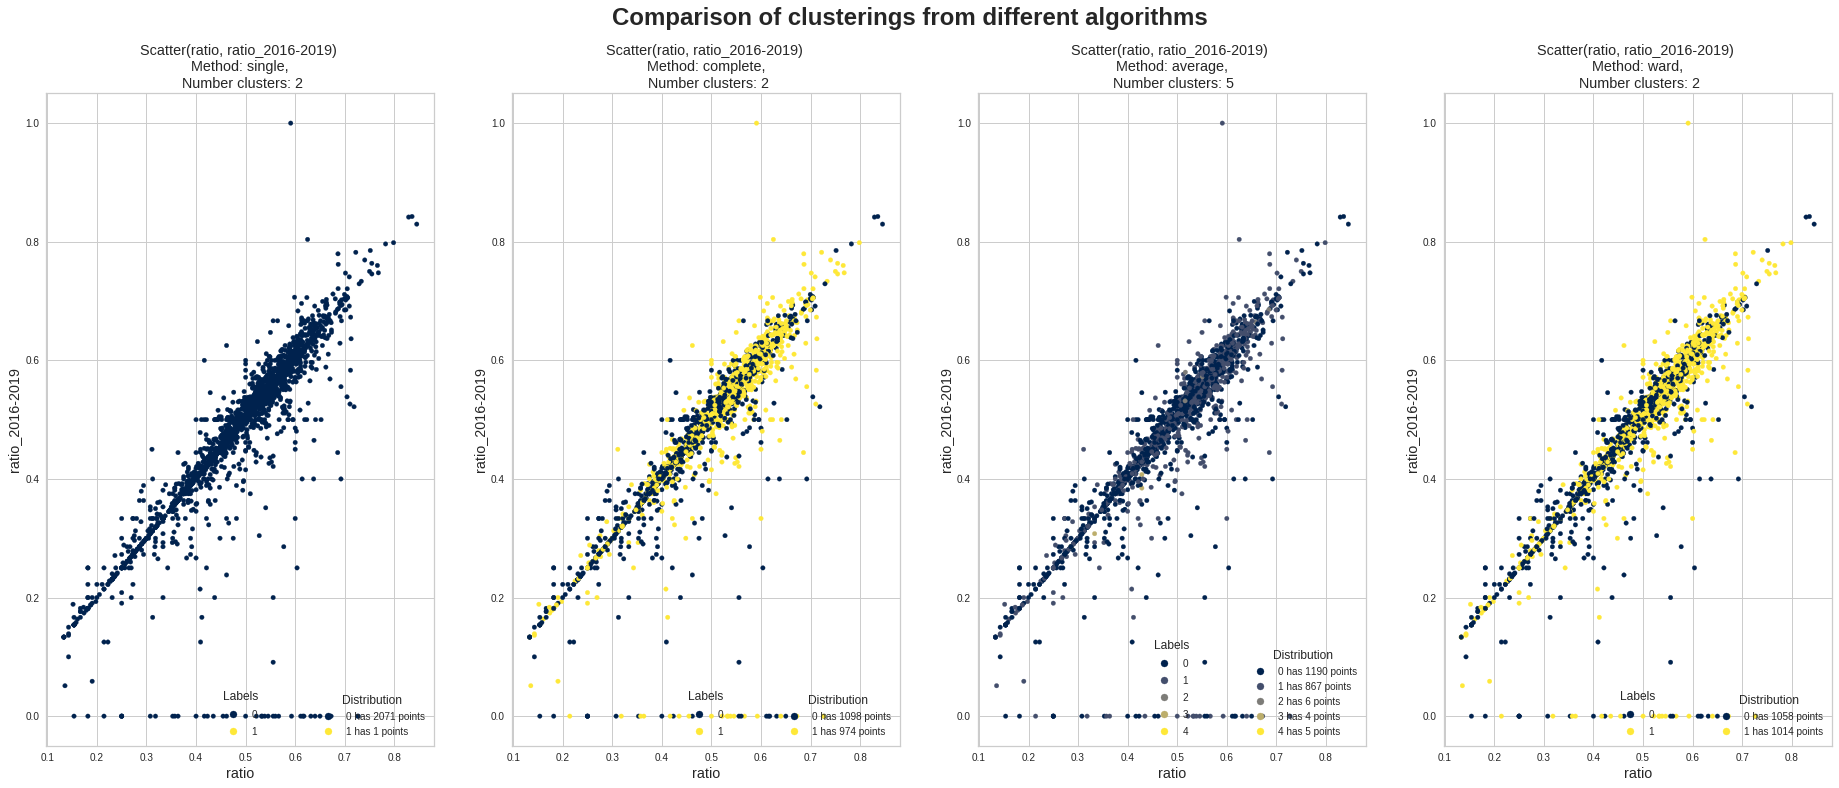

In [33]:
a, b = 'ratio', 'ratio_2016-2019'
comparison(a,b)

### num_matches_2020-2021 - ratio_2020-2021

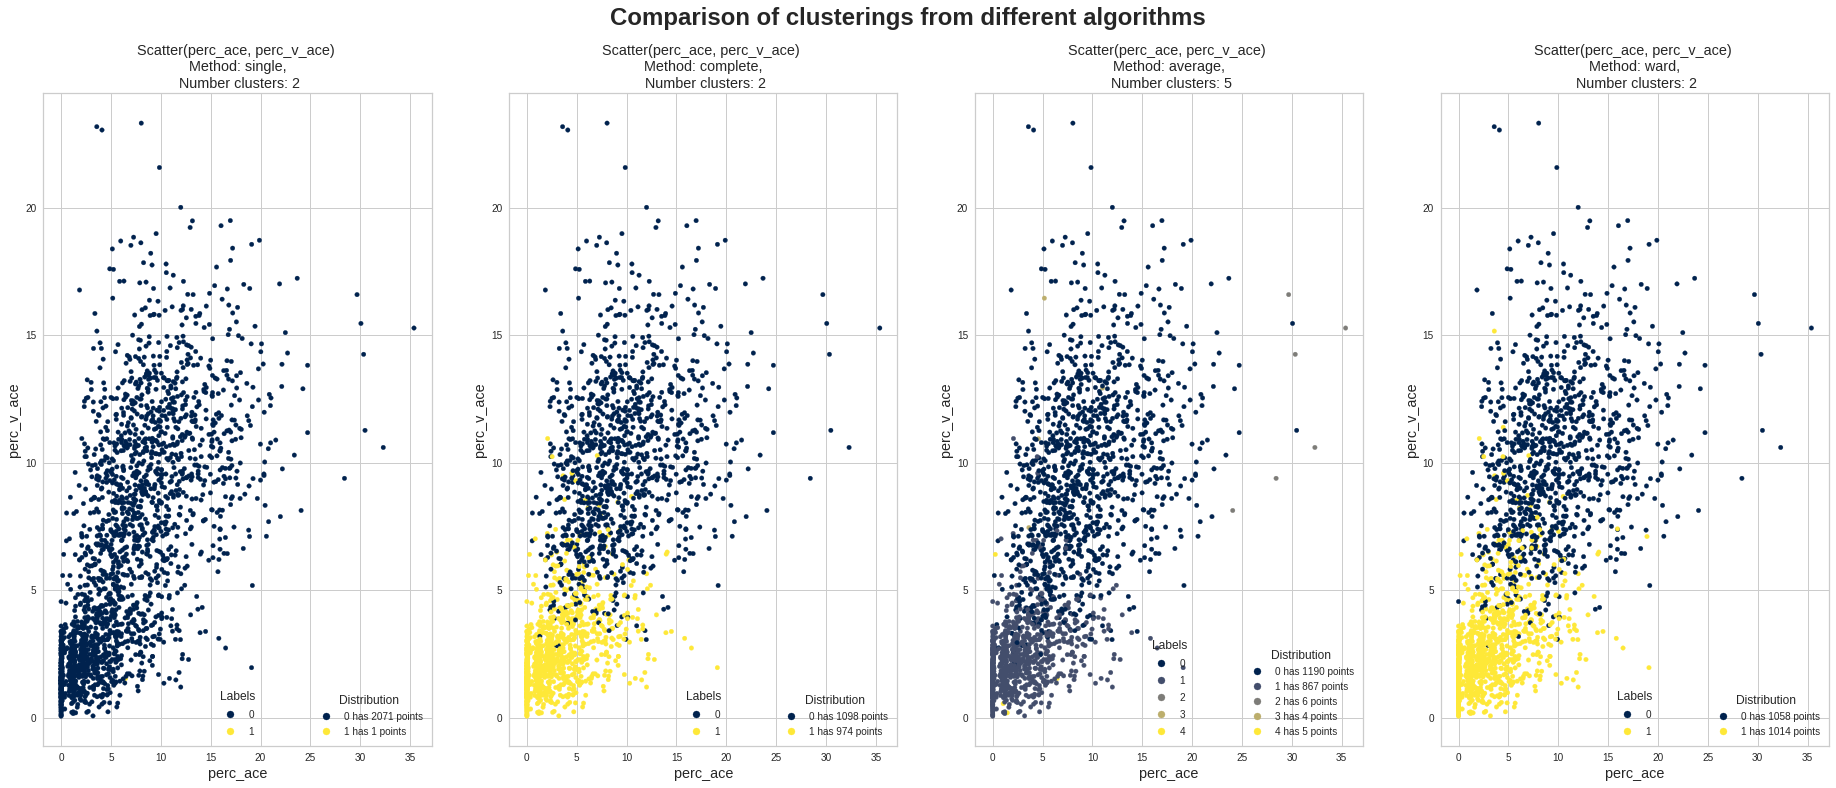

In [34]:
a, b = 'perc_ace', 'perc_v_ace'
comparison(a,b)

## Evaluation

In [35]:
metrics=pd.DataFrame() # we create a dataframe to contain the results of the evaluation
    
sep=[]
sil=[]
cal_har=[]
cophenetic_coefficients = []

for method in methods:
    sep.append(davies_bouldin_score(data, clusters_labels[method]))
    sil.append(silhouette_score(data, clusters_labels[method]))
    cal_har.append(calinski_harabasz_score(data, clusters_labels[method]))
    Z = linkage(data, method)
    cophenetic_coefficients = np.append(cophenetic_coefficients, np.corrcoef(pdist(data), cophenet(Z))[0][1])
    
#internal metric
metrics['Methods'] = methods
metrics['Davies_Bouldini'] = sep
metrics['Silhouette'] = sil
metrics['Calinski_Harabasz'] = cal_har

#esternal metric
metrics['cophenetic_corr'] = cophenetic_coefficients

#set index to methods
metrics.set_index(['Methods'], inplace=True)
metrics

,Davies_Bouldini,Silhouette,Calinski_Harabasz,cophenetic_corr
Methods,,,,
single,0.684837,0.199751,2.014265,0.264950
complete,1.429738,0.288007,934.473150,0.618364
average,1.273799,0.181079,235.069240,0.671110
ward,1.442171,0.284544,919.360115,0.631931


### X-MEANS (extra)

In [36]:
mat = np.asmatrix(data).tolist()

In [37]:
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.encoder import type_encoding, cluster_encoder

In [38]:
scaled = np.array(scaled)

In [39]:
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(mat, amount_initial_centers).initialize()
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 10.
xmeans_instance = xmeans(mat, initial_centers, 6, ccore=False)
xmeans_instance.process()


# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
# Visualize clustering results

# by default k-means returns representation CLUSTER_INDEX_LIST_SEPARATION
type_repr = xmeans_instance.get_cluster_encoding();
encoder = cluster_encoder(type_repr, clusters, mat);
# change representation from index list to label list
encoder.set_encoding(type_encoding.CLUSTER_INDEX_LABELING);

#print("Index Labeling:", encoder.get_clusters())

## Validation

In [40]:
#print("Number of clusters: ",encoder.get_clusters())
from pyclustering.cluster.silhouette import silhouette 
score = silhouette(mat, clusters).process().get_score()
res = sum(score)/len(score)
print(res)

0.3943134560609507


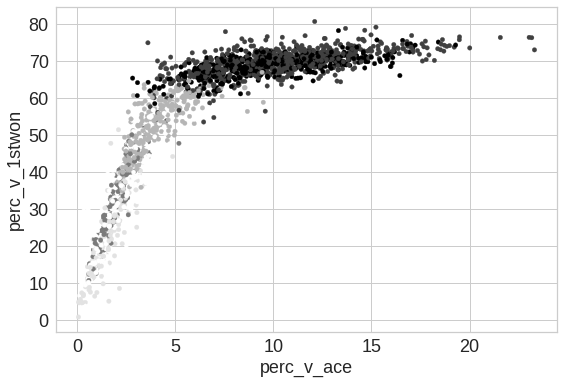

In [41]:
plt.scatter(df['perc_v_ace'], df['perc_v_1stwon'], c=encoder.get_clusters(), s=20)
plt.tick_params(labelsize=18)
plt.xlabel("perc_v_ace",fontsize=18)
plt.ylabel("perc_v_1stwon",fontsize=18)
plt.tight_layout()
plt.show()